In [12]:
import argparse
import argparse
import math
from dataclasses import dataclass
from typing import Tuple, Optional

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [25]:
natgas_df = pd.read_csv("Nat_Gas.csv")
natgas_df

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


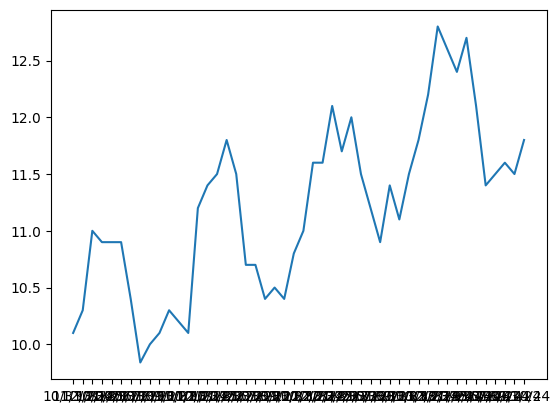

In [27]:
plt.plot(natgas_df['Dates'], natgas_df['Prices'])

In [13]:
def to_month_end(dt: pd.Timestamp) -> pd.Timestamp:
    """Normalize any date to its month-end timestamp."""
    return dt.to_period('M').to_timestamp('M')


def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Symmetric MAPE in percent."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1.0, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

In [14]:
@dataclass
class FitReport:
    rmse: float
    smape: float
    baseline_rmse: float
    baseline_smape: float
    n_test: int

In [18]:
class NatGasModel:
    """
    Trend + Seasonality model on monthly end-of-month (EOM) prices.
    - Fits: price_t = β0 + β1 * t + Σ γ_m * 1{month=m} + ε
    - Creates monthly nodes (historic + future 12 months)
    - For any date: linearly interpolate between surrounding nodes.
    """

    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = self._load_and_clean(csv_path)             # monthly EOM index, col 'Price'
        self.model: Optional[LinearRegression] = None
        self.X_columns: Optional[list] = None
        self.nodes: Optional[pd.Series] = None               # monthly node prices (history + forecast)
        self.first_eom: pd.Timestamp = self.df.index.min()
        self.last_hist_eom: pd.Timestamp = self.df.index.max()

    # ---------- data ----------

    def _load_and_clean(self, path: str) -> pd.DataFrame:
        # Read, accept flexible col names
        raw = pd.read_csv(path)
        cols = {c.lower(): c for c in raw.columns}
        date_col = cols.get('dates') or cols.get('date')
        price_col = cols.get('prices') or cols.get('price')
        if not date_col or not price_col:
            raise ValueError("CSV must contain 'Dates' and 'Prices' columns (case-insensitive).")

        df = raw[[date_col, price_col]].copy()
        # Parse dates robustly
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=[date_col])

        # Coerce prices
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
        df = df.dropna(subset=[price_col])

        # Normalize to month-end and aggregate if duplicates
        df['eom'] = df[date_col].apply(to_month_end)
        df = df.groupby('eom', as_index=False)[price_col].mean()

        # Reindex to full monthly EOM grid (fill small gaps by linear interpolation)
        idx = pd.date_range(df['eom'].min(), df['eom'].max(), freq='ME')
        df = df.set_index('eom').reindex(idx)
        df.columns = ['Price']
        df.index.name = 'Date'
        df['Price'] = df['Price'].interpolate('time').bfill().ffill()

        return df

    # ---------- features ----------

    def _design_matrix(self, idx: pd.DatetimeIndex) -> pd.DataFrame:
        """
        Build design matrix for given EOM idx: columns = ['t'] + month dummies (drop_first=True).
        """
        base = pd.DataFrame(index=idx)
        # t = integer month counter from first EOM
        first_period = self.first_eom.to_period('M')
        idx_periods = idx.to_period('M')
        months_since_start = (idx_periods.year - first_period.year) * 12 + (idx_periods.month - first_period.month)
        base['t'] = months_since_start
        base['month'] = idx.month
        X = pd.get_dummies(base, columns=['month'], drop_first=True)
        # Ensure column order matches training columns (when predicting later)
        if self.X_columns is not None:
            for c in self.X_columns:
                if c not in X.columns:
                    X[c] = 0
            X = X[self.X_columns]
        return X

    # ---------- fitting & backtest ----------

    def fit(self) -> FitReport:
        """
        Backtest on last 12 months, then refit on all data.
        Returns metrics comparing model vs seasonal-naive baseline.
        """
        # Split train/test (last 12 months)
        n = len(self.df)
        n_test = min(12, max(1, n // 4))
        train_idx = self.df.index[: n - n_test]
        test_idx = self.df.index[n - n_test:]

        # Train model on train_idx
        X_train = self._design_matrix(train_idx)
        y_train = self.df.loc[train_idx, 'Price'].values
        self.model = LinearRegression().fit(X_train, y_train)
        self.X_columns = list(X_train.columns)  # lock column order

        # Predict on test
        X_test = self._design_matrix(test_idx)
        pred_test = self.model.predict(X_test)
        y_test = self.df.loc[test_idx, 'Price'].values

        # Seasonal-naive baseline: last year's same month (where available), otherwise carry-forward
        baseline = []
        for dt in test_idx:
            prev = dt - pd.DateOffset(years=1)
            if prev in self.df.index:
                baseline.append(self.df.loc[prev, 'Price'])
            else:
                # fallback: previous month
                prev_m = dt - pd.DateOffset(months=1)
                if prev_m in self.df.index:
                    baseline.append(self.df.loc[prev_m, 'Price'])
                else:
                    baseline.append(self.df.loc[train_idx[-1], 'Price'])
        baseline = np.array(baseline, dtype=float)

        rep = FitReport(
            rmse=rmse(y_test, pred_test),
            smape=smape(y_test, pred_test),
            baseline_rmse=rmse(y_test, baseline),
            baseline_smape=smape(y_test, baseline),
            n_test=len(test_idx),
        )

        # Refit on ALL data for production nodes
        X_all = self._design_matrix(self.df.index)
        y_all = self.df['Price'].values
        self.model = LinearRegression().fit(X_all, y_all)
        self.X_columns = list(X_all.columns)

        # Build forecast nodes: history + 12 months ahead
        last_eom = self.df.index.max()
        future_idx = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=12, freq='ME')
        node_idx = self.df.index.union(future_idx)
        X_nodes = self._design_matrix(node_idx)
        node_pred = self.model.predict(X_nodes)
        self.nodes = pd.Series(node_pred, index=node_idx, name='node_price')

        return rep

    # ---------- pricing API ----------

    def _interp_between_nodes(self, dt: pd.Timestamp) -> float:
        """
        Linearly interpolate price between surrounding month-end nodes for an arbitrary date dt.
        """
        if dt in self.nodes.index:
            return float(self.nodes.loc[dt])

        prev_eom = to_month_end(dt - pd.offsets.MonthBegin(1))  # last EOM at or before dt
        next_eom = to_month_end(dt) if dt > to_month_end(dt) else to_month_end(dt)  # handle mid-month
        # Correct prev/next around mid-month date:
        prev_eom = to_month_end(dt.to_period('M').to_timestamp('M') - pd.offsets.MonthEnd(1))
        next_eom = to_month_end(dt)

        # If dt is exactly EOM, above can mis-handle; fix:
        if dt == next_eom:
            prev_eom = to_month_end(dt - pd.offsets.MonthEnd(1))

        # Guard: if outside node range, clamp to ends
        if dt < self.nodes.index.min():
            return float(self.nodes.iloc[0])
        if dt > self.nodes.index.max():
            return float(self.nodes.iloc[-1])

        # Ensure prev/next exist in nodes; if not, pick closest available
        if prev_eom not in self.nodes.index:
            prev_eom = max([d for d in self.nodes.index if d <= dt])
        if next_eom not in self.nodes.index:
            next_eom = min([d for d in self.nodes.index if d >= dt])

        p0 = float(self.nodes.loc[prev_eom])
        p1 = float(self.nodes.loc[next_eom])
        if next_eom == prev_eom:
            return p0

        # fraction of month elapsed
        frac = (dt - prev_eom) / (next_eom - prev_eom)
        return float(p0 + frac * (p1 - p0))

    def get_price(self, date_input: str) -> dict:
        """
        Public API: date string -> price estimate with method & confidence.
        Accepts formats like YYYY-MM-DD, MM/DD/YYYY, etc.
        """
        try:
            dt = pd.to_datetime(date_input)
        except Exception:
            return {"error": "Invalid date format. Try YYYY-MM-DD or MM/DD/YYYY."}

        # Ensure model fitted and nodes ready
        if self.nodes is None:
            _ = self.fit()

        dt = pd.Timestamp(dt)
        # Historical exact/interpolated (within known range)
        if self.first_eom <= dt <= self.last_hist_eom:
            # Interpolate between historical monthly points
            price = self._interp_between_nodes(dt)
            meth = "Historical (Exact/Interpolated)"
            conf = "High" if dt in self.df.index else "Medium-High"
            return {"date": dt.date().isoformat(), "price": round(price, 4), "method": meth, "confidence": conf}

        # Future within forecast horizon
        if dt > self.last_hist_eom and dt <= self.nodes.index.max():
            price = self._interp_between_nodes(dt)
            meth = "Forecast (Trend + Month-of-Year) + Interpolation"
            # Lower confidence further out in time
            days_ahead = (dt - self.last_hist_eom).days
            conf = "Medium" if days_ahead <= 365 else "Low"
            return {"date": dt.date().isoformat(), "price": round(price, 4), "method": meth, "confidence": conf}

        # Outside range: clamp gracefully
        if dt < self.first_eom:
            price = float(self.df.iloc[0]['Price'])
            return {"date": dt.date().isoformat(), "price": round(price, 4), "method": "Clamped to earliest", "confidence": "Low"}

        # Beyond nodes max
        price = float(self.nodes.iloc[-1])
        return {"date": dt.date().isoformat(), "price": round(price, 4), "method": "Clamped to latest forecast node", "confidence": "Low"}

    # ---------- outputs ----------

    def forecast_table(self, months_ahead: int = 12) -> pd.DataFrame:
        """Return a dataframe of monthly node forecasts (EOM) for next N months."""
        if self.nodes is None:
            _ = self.fit()
        last_hist = self.last_hist_eom
        future_idx = pd.date_range(last_hist + pd.offsets.MonthEnd(1), periods=months_ahead, freq='ME')
        out = pd.DataFrame({
            "Price": self.nodes.reindex(future_idx)
        })
        out.index.name = "Date"
        return out

    def plot(self):
        """Plot actual vs fitted + forecast nodes, and seasonal bars."""
        if self.nodes is None or self.model is None:
            rep = self.fit()
            # optional: print metrics
            print(f"[Backtest {rep.n_test}m] Model RMSE={rep.rmse:.3f} (baseline {rep.baseline_rmse:.3f}) "
                  f"| sMAPE={rep.smape:.2f}% (baseline {rep.baseline_smape:.2f}%)")

        # Figure 1: time series + nodes
        plt.figure(figsize=(10, 5))
        plt.plot(self.df.index, self.df['Price'].values, label="Actual (EOM)")
        plt.plot(self.nodes.index, self.nodes.values, linestyle='--', label="Fitted + 12m Forecast (Nodes)")
        plt.title("Natural Gas Price — Actual vs Fitted/Forecast")
        plt.xlabel("Date"); plt.ylabel("Price")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Figure 2: average by month (seasonality)
        mo_avg = self.df.groupby(self.df.index.month)['Price'].mean()
        plt.figure(figsize=(8, 4))
        plt.bar(range(1, 13), mo_avg.values)
        plt.xticks(range(1, 13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
        plt.title("Average Price by Month"); plt.xlabel("Month"); plt.ylabel("Avg Price")
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Seasonality (avg by month)
        mo_avg = self.df.groupby(self.df.index.month)['Price'].mean()
        plt.figure(figsize=(8,4))
        plt.bar(range(1,13), mo_avg.values)
        plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
        plt.title("Average Price by Month"); plt.xlabel("Month"); plt.ylabel("Avg Price")
        plt.grid(True, axis='y', alpha=0.3); plt.tight_layout()
        plt.show()


In [20]:
CSV_PATH = "Nat_Gas.csv"   

model = NatGasModel(CSV_PATH)
report = model.fit()

print(f"[Holdout (last {report.n_test} months)]")
print(f"Model    → RMSE={report.rmse:.3f} | sMAPE={report.smape:.2f}%")
print(f"Naive(Same month last year) → RMSE={report.baseline_rmse:.3f} | sMAPE={report.baseline_smape:.2f}%")


[Holdout (last 12 months)]
Model    → RMSE=0.201 | sMAPE=1.39%
Naive(Same month last year) → RMSE=0.627 | sMAPE=4.79%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17404\3113414739.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


In [21]:
#query examples + 12m forecast table

dates_to_test = [
    "2022-01-31",  # exact historical EOM
    "2022-02-15",  # intramonth historical interpolation
    "2025-01-15",  # within 12m forecast horizon
    "2026-01-15"   # beyond horizon -> clamped
]

for d in dates_to_test:
    print(model.get_price(d))

# 12-month forecast (EOM nodes)
forecast_12m = model.forecast_table(12)
forecast_12m


{'date': '2022-01-31', 'price': 11.5042, 'method': 'Historical (Exact/Interpolated)', 'confidence': 'High'}
{'date': '2022-02-15', 'price': 11.4641, 'method': 'Historical (Exact/Interpolated)', 'confidence': 'Medium-High'}
{'date': '2025-01-15', 'price': 13.09, 'method': 'Forecast (Trend + Month-of-Year) + Interpolation', 'confidence': 'Medium'}
{'date': '2026-01-15', 'price': 12.4287, 'method': 'Clamped to latest forecast node', 'confidence': 'Low'}


,Price
Date,
2024-10-31,12.10375
2024-11-30,12.67875
2024-12-31,13.05375
2025-01-31,13.12875
2025-02-28,13.05375
2025-03-31,13.12875
2025-04-30,12.52875
2025-05-31,12.13875
2025-06-30,12.05375


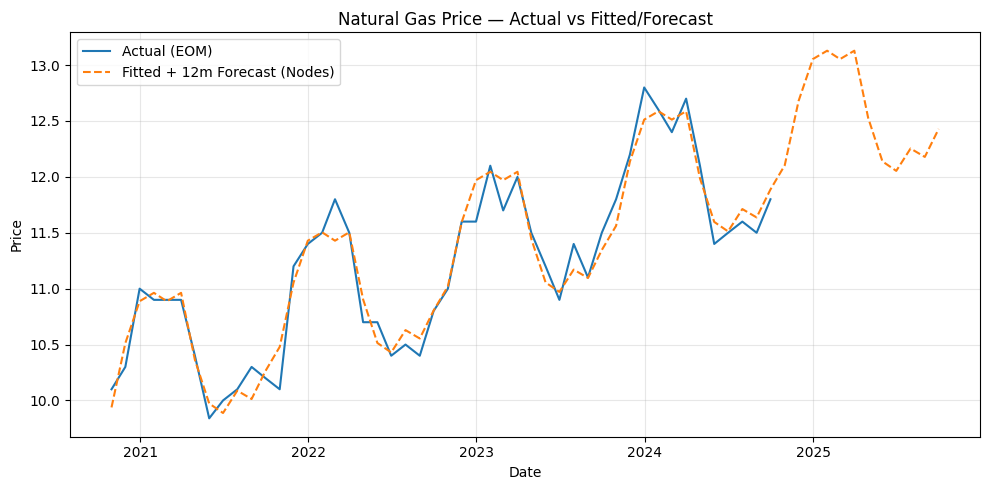

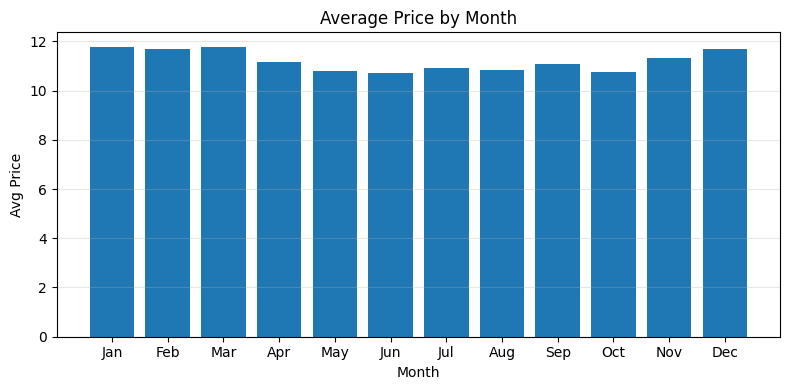

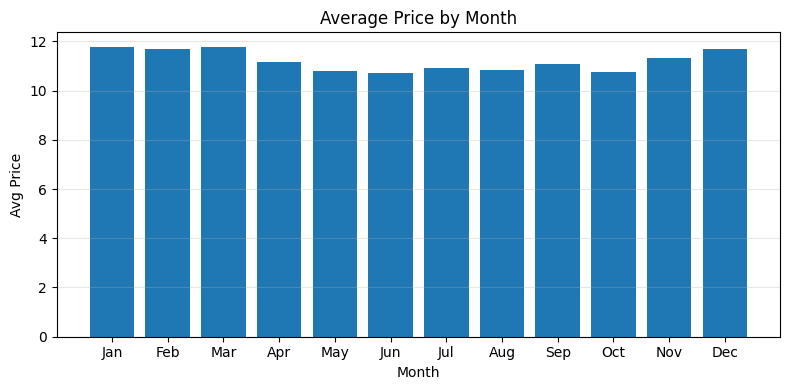

In [22]:
model.plot()